In [2]:
# Copied from visualization
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from glob import glob
from scipy.ndimage import gaussian_filter
from tensorflow.image import rot90
np.random.seed(42)

# Paths to the image and label directories
image_dir_2014 = './images/train/2014'
image_dir_2015 = './images/train/2015'
image_dir_2016 = './images/train/2016'
label_train = './labels/train'
testimage_dir = './images/test/2023'
label_test = './labels/test'

# Labels as categories
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

# Get all image files from 2014, 2015, and 2016
image_files_2014 = sorted(glob(os.path.join(image_dir_2014, '*.tif')))
image_files_2015 = sorted(glob(os.path.join(image_dir_2015, '*.tif')))
image_files_2016 = sorted(glob(os.path.join(image_dir_2016, '*.tif')))
# Get all image files for test
testimage_files = sorted(glob(os.path.join(testimage_dir, '*.tif')))


# Get all label files for train and test
label_files = sorted(glob(os.path.join(label_train, '*.tif')))
testlabel_files = sorted(glob(os.path.join(label_test, '*.tif')))

# Data preprocessing (baseline, 2016 data only)

In [3]:
def extract_channels(fileList):
    images = []
    for filename in fileList:
        with rasterio.open(filename) as src:
            data = np.dstack([src.read(7), src.read(6), src.read(5), src.read(4), src.read(3), src.read(2), src.read(1)])
            images.append(data)
    return np.array(images)

def extract_labels(fileList):
    labels = []
    for filename in fileList:
        with rasterio.open(filename) as src:
            data = src.read(1)
            labels.append(data)
    return np.array(labels)

def one_hot_labels(value, length):
    return np.eye(length, dtype=int)[value]

In [4]:
# We extract images from 2016 and their corresponding labels
images = extract_channels(image_files_2016)
labels = extract_labels(label_files)

In [5]:
# Get shuffled indices, for train/validation split
shuffled_indices = [i for i in range(len(images))]
np.random.shuffle(shuffled_indices)

In [6]:
# Split indices into train/validation
val_split = 0.2
split_index = round(val_split * len(images))

val_indices = shuffled_indices[:split_index]
train_indices = shuffled_indices[split_index:]

In [7]:
# Split images from 2016 and labels into train/validation
train_images = images[train_indices]
val_images = images[val_indices]
train_labels = labels[train_indices]
val_labels = labels[val_indices]

In [8]:
# One-hot encode the labels. Each label should be of shape (128, 128, 7)
one_hot_train_labels = one_hot_labels(train_labels, len(label_names))
one_hot_val_labels = one_hot_labels(val_labels, len(label_names))
one_hot_train_labels.shape

(1200, 128, 128, 7)

In [9]:
# Create folder if it doesn't exist
folder_path = "cache/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [10]:
# Save the preprocessed data for 2016 (our baseline) into a single .npz file
# Takes ~1 minute
np.savez_compressed(
    "cache/unchanged_data_2016.npz",
    train_data=train_images,
    train_labels=one_hot_train_labels,
    val_data=val_images,
    val_labels=one_hot_val_labels
)

# Data preprocessing (all years)

In [12]:
# Extract images from 2015 and 2014. The labels are the same, our dataset contains 3 images per label (one image for each year)
images_2015 = extract_channels(image_files_2015)
images_2014 = extract_channels(image_files_2014)

In [13]:
# Split the 2015 and 2014 data into train/validation
train_images_2015 = images_2015[train_indices]
train_images_2014 = images_2014[train_indices]

val_images_2015 = images_2015[val_indices]
val_images_2014 = images_2014[val_indices]

In [14]:
# Concatenate the images together
train_images_full = np.concatenate([train_images, train_images_2015, train_images_2014])
val_images_full = np.concatenate([val_images, val_images_2015, val_images_2014])

# Concatenate 3 copies of each set of labels together. This is to ensure that we have 1 label per image
# (the dataset has 3 images per label, so here we split them up into individual training datapoints)
train_labels_full = np.concatenate([train_labels, train_labels, train_labels])
val_labels_full = np.concatenate([val_labels, val_labels, val_labels])

# One-hot encode the labels
one_hot_train_labels_full = one_hot_labels(train_labels_full, len(label_names))
one_hot_val_labels_full = one_hot_labels(val_labels_full, len(label_names))

In [15]:
# Save the preprocessed data from all 3 years into a single .npz file
# Takes ~2.5 minutes
np.savez_compressed(
    "cache/unchanged_data_all_years.npz",
    train_data=train_images_full,
    train_labels=one_hot_train_labels_full,
    val_data=val_images_full,
    val_labels=one_hot_val_labels_full
)

In [17]:
# Free up memory
del train_images_full, val_images_full, train_labels_full, val_labels_full, one_hot_train_labels_full, one_hot_val_labels_full, images_2015, images_2014

# Data augmentation (Using 2016 data)

In [18]:
# Generate sets of rotated images and labels. It is essential that the labels are also rotated.
rotated_images_1 = rot90(train_images)
rotated_labels_1 = rot90(one_hot_train_labels)

rotated_images_2 = rot90(rotated_images_1)
rotated_labels_2 = rot90(rotated_labels_1)

rotated_images_3 = rot90(rotated_images_2)
rotated_labels_3 = rot90(rotated_labels_2)

# Apply Gaussian filter
sigma = 0.5 # Sigma value found through experimentation. This value seems to produce reasonable image quality but visible changes.
gaussian_data = gaussian_filter(train_images, sigma)
# Gaussian filter labels are unchanged
gaussian_labels = one_hot_train_labels

2024-12-13 13:56:56.596862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Function for getting rgb images to plot from the 7-dimensional image data
def get_rgb_img(image):
    rgb_img = image[:, :, :3]
    rgb_img = rgb_img / np.max(rgb_img)
    return rgb_img

# Example image to plot
idx = 42

augmented_img = gaussian_data[idx]
rgb_aug = get_rgb_img(augmented_img)

unaugmented_img = train_images[idx]
rgb = get_rgb_img(unaugmented_img)

rotated_img = rotated_images_1[idx]
rgb_rot = get_rgb_img(rotated_img)

Text(0.5, 1.0, 'Rotated label')

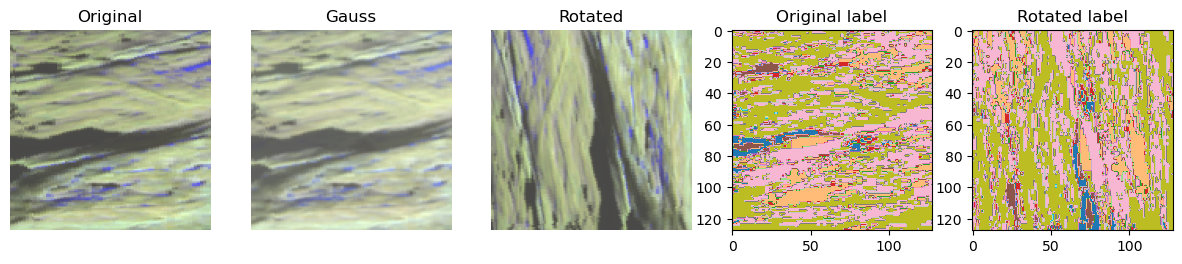

In [20]:
# Plot the image with variations and corresponding labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(rgb)
axes[0].set_title(f"Original")
axes[0].axis('off')


axes[1].imshow(rgb_aug)
axes[1].set_title(f"Gauss")
axes[1].axis('off')


axes[2].imshow(rgb_rot)
axes[2].set_title(f"Rotated")
axes[2].axis('off')



axes[3].imshow(np.argmax(one_hot_train_labels[idx], axis=-1), cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[3].set_title(f"Original label")

axes[4].imshow(np.argmax(rotated_labels_1[idx], axis=-1), cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[4].set_title("Rotated label")

In [21]:
# Concatenate together train data and labels
full_train_data = np.concatenate([train_images, rotated_images_1, rotated_images_2, rotated_images_3, gaussian_data])
del train_images, rotated_images_1, rotated_images_2, rotated_images_3, gaussian_data # Free up memory

full_train_labels = np.concatenate([one_hot_train_labels, rotated_labels_1, rotated_labels_2, rotated_labels_3, gaussian_labels])
del one_hot_train_labels, rotated_labels_1, rotated_labels_2, rotated_labels_3, gaussian_labels # Free up memory

print(full_train_data.shape)
print(full_train_labels.shape)

(6000, 128, 128, 7)
(6000, 128, 128, 7)


In [22]:
# Save the augmented data into a single .npz file
# Takes ~4 minutes
np.savez_compressed(
    "cache/augmented_data.npz",
    train_data=full_train_data,
    train_labels=full_train_labels,
    val_data=val_images,
    val_labels=one_hot_val_labels
)